In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import time
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

np.random.seed(123)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

C:\Users\alire\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
num = ['Page Popularity Likes', 'Page Checkins', 'Page Talking About', 'Page Category', 
            'CC1 Min', 'CC1 Max', 'CC1 Avg', 'CC1 Median', 'CC1 Std', 
            'CC2 Min', 'CC2 Max', 'CC2 Avg', 'CC2 Median', 'CC2 Std', 
            'CC3 Min', 'CC3 Max', 'CC3 Avg', 'CC3 Median', 'CC3 Std', 
            'CC4 Min', 'CC4 Max', 'CC4 Avg', 'CC4 Median', 'CC4 Std', 
            'CC5 Min', 'CC5 Max', 'CC5 Avg', 'CC5 Median', 'CC5 Std',
            'CC1', 'CC2', 'CC3', 'CC4', 'CC5', 
            'Base Time', 'Post Length', 'Post Share Count', 'Post Promotion Status', 'H Local']

cat = ['SunP', 'MonP', 'TueP', 'WedP', 'ThuP', 'FriP', 'SatP', 
                        'SunB', 'MonB', 'TuesB', 'WedB', 'ThuB', 'FriB', 'SatB']

features = num + cat + ['Target N in Next H Hours']


#parse data
train_data = []
test_data = []
train_labels = []
test_labels = []

for i in range(1, 6):
    train_data.append( pd.read_csv("./Dataset/Training/Features_Variant_" + str(i) + ".csv", names = features) )
    train_labels.append(train_data[i - 1]['Target N in Next H Hours'].values)
    train_data[i - 1].drop(['Target N in Next H Hours'], axis=1, inplace=True)
for i in range(1, 11):
    test_data.append( pd.read_csv("./Dataset/Testing/TestSet/Test_Case_" + str(i) + ".csv", names = features) )
    test_labels.append(test_data[i - 1]['Target N in Next H Hours'].values)
    test_data[i - 1].drop(['Target N in Next H Hours'], axis=1, inplace=True)

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num)),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat))
    ])


from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
            ("num_pipeline", num_pipeline),
            ("cat_pipeline", cat_pipeline)
    
    ])

#normalize
train_data_norm = list(map(lambda a: full_pipeline.fit_transform(a), train_data ))
test_data_norm = list(map(lambda a: full_pipeline.fit_transform(a), test_data ))
print(train_data_norm[4].shape)
train_data[0].shape

(199030, 53)


(40949, 53)

In [4]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

def getTop10Labels(arg):
    #print("arg: " , arg)
    top10 =  sorted( zip( list(range(len(arg))), arg), key = lambda a: a[1], reverse = True)[:10]
    #print("top 10: " , top10)
    return list( map(lambda a: a[0], top10) )

def get10Hits_AUC(X, labels, model,ith, comment_strings):
    predict = model.predict(X)
    hits = np.intersect1d(getTop10Labels(labels), getTop10Labels(predict)).shape[0]
    print("Hits using tarining variant_"+str(i)+" in "+comment_strings+" : ",hits)
    top10_predicted = sorted(predict)[-10:]
    top10_labels = sorted(labels)[-10:]

    pred_binary = predict >= top10_predicted[0]
    labels_binary = labels >= top10_labels[0]

    return hits,roc_auc_score(labels_binary, pred_binary), mean_squared_error(labels, predict)

In [5]:
all_results_1Hidden_4nodes = []
for i in range(5):
    model = Sequential()
    model.add(Dense(4, activation='relu', input_shape=(train_data_norm[0].shape[1],)))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_squared_error'])
    early_stopping_monitor = EarlyStopping(patience=3)
    model.fit(train_data_norm[i], train_labels[i], validation_split=0.2, epochs=500, callbacks=[early_stopping_monitor],shuffle=False,verbose=0)
    training_results = get10Hits_AUC(train_data_norm[i], train_labels[i], model,i,"Training Sets")
    testing_results = get10Hits_AUC(test_data_norm[i], test_labels[i], model,i,"Test Sets")
    result = list(zip(training_results, testing_results))
    all_results_1Hidden_4nodes.append(result)
print("----------------------------------------------------------------")
all_results_2Hidden_10_4 = []
for i in range(5):
    model = Sequential()
    model.add(Dense(10, activation='relu', input_shape=(train_data_norm[0].shape[1],)))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_squared_error'])
    early_stopping_monitor = EarlyStopping(patience=3)
    model.fit(train_data_norm[i], train_labels[i], validation_split=0.2, epochs=500, callbacks=[early_stopping_monitor],shuffle=False,verbose=0)
    training_results = get10Hits_AUC(train_data_norm[i], train_labels[i], model,i,"Training Sets")
    testing_results = get10Hits_AUC(test_data_norm[i], test_labels[i], model,i,"Test Sets")
    result = list(zip(training_results, testing_results))
    all_results_2Hidden_10_4.append(result)
print("----------------------------------------------------------------")
all_results_5Hidden_100 = []
for i in range(5):
    model = Sequential()
    model.add(Dense(200, activation='relu', input_shape=(train_data_norm[0].shape[1],)))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_squared_error'])
    early_stopping_monitor = EarlyStopping(patience=3)
    model.fit(train_data_norm[i], train_labels[i], validation_split=0.2, epochs=500, callbacks=[early_stopping_monitor],shuffle=False,verbose=0)
    training_results = get10Hits_AUC(train_data_norm[i], train_labels[i], model,i,"Training Sets")
    testing_results = get10Hits_AUC(test_data_norm[i], test_labels[i], model,i,"Test Sets")
    result = list(zip(training_results, testing_results))
    all_results_5Hidden_100.append(result)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Hits using tarining variant_0 in Training Sets :  0
Hits using tarining variant_0 in Test Sets :  4
Hits using tarining variant_1 in Training Sets :  0
Hits using tarining variant_1 in Test Sets :  5
Hits using tarining variant_2 in Training Sets :  1
Hits using tarining variant_2 in Test Sets :  5
Hits using tarining variant_3 in Training Sets :  0
Hits using tarining variant_3 in Test Sets :  7
Hits using tarining variant_4 in Training Sets :  0
Hits using tarining variant_4 in Test Sets :  5
----------------------------------------------------------------
Hits using tarining variant_0 in Training Sets :  1
Hits using tarining variant_0 in Test Sets :  6
Hits using tarining variant_1 in Training Sets :  0
Hits using tarining variant_1 in Test Sets :  5
Hits using tarining variant_2 in Training Sets :  2
Hits using tarining variant_2 in Test Sets :  4
Hits using tari

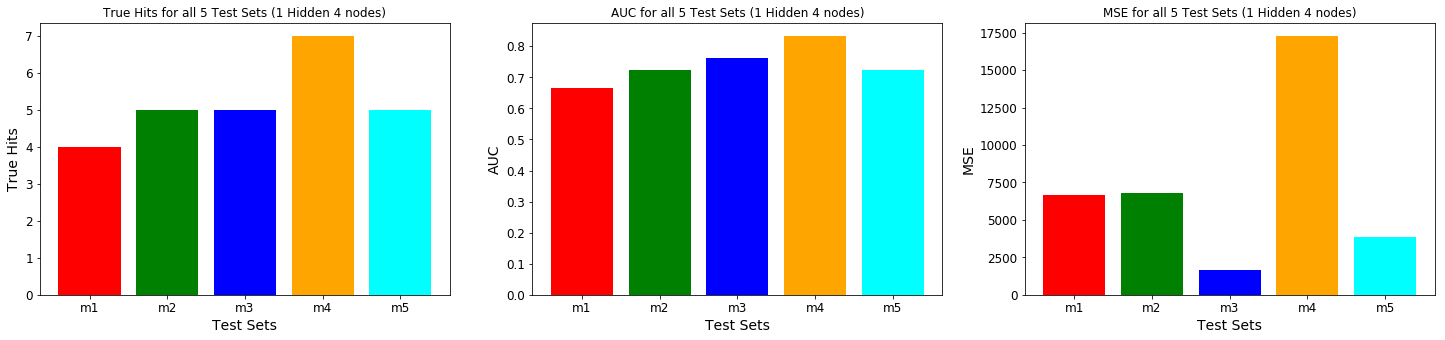

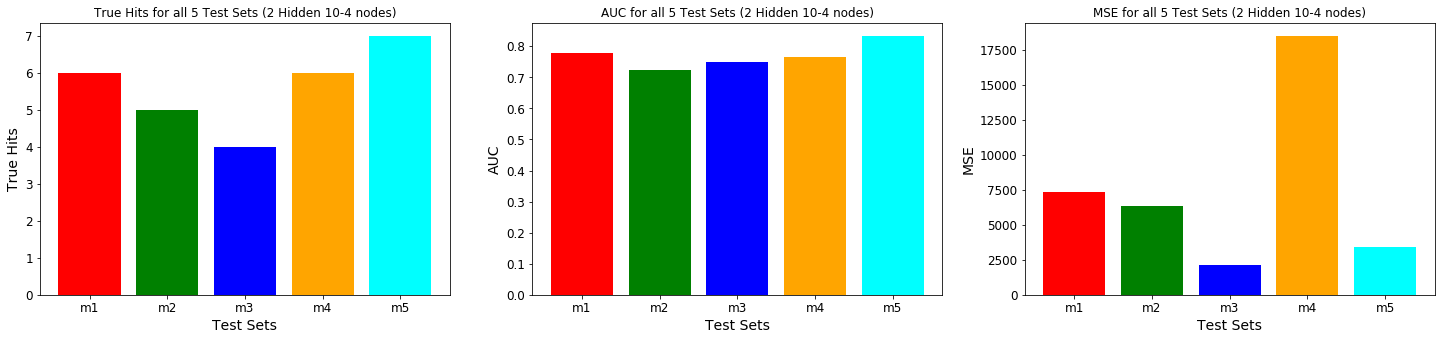

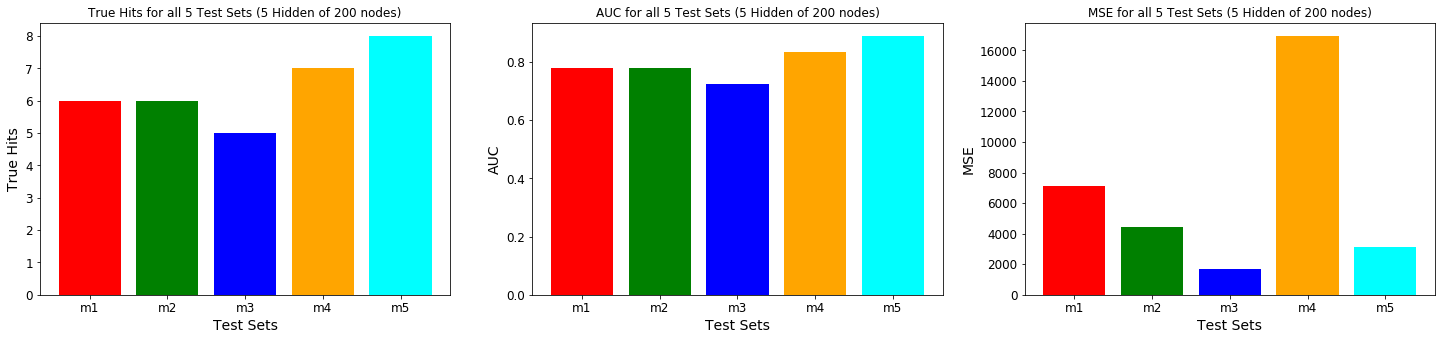

In [7]:
def plot_results(results,comment_string):   
    colors=['red', 'green', 'blue', 'orange', 'cyan']
    plt.figure(figsize=(25, 5))
    x_hits = ['m1','m2','m3','m4','m5']

    plt.subplot(131)
    y_hits=  list(map(lambda a: a[0][1], results ))
    plt.bar(x_hits, y_hits, color=colors)
    plt.xlabel('Test Sets')
    plt.ylabel('True Hits')
    plt.title('True Hits for all 5 Test Sets '+comment_string)

    plt.subplot(132)
    y_hits=  list(map(lambda a: a[1][1], results ))
    plt.bar(x_hits, y_hits, color=colors)
    plt.xlabel('Test Sets')
    plt.ylabel('AUC')
    plt.title('AUC for all 5 Test Sets '+comment_string)

    plt.subplot(133)
    y_hits=  list(map(lambda a: a[2][1], results ))
    width = 1/1.5
    plt.bar(x_hits, y_hits, color=colors)
    plt.xlabel('Test Sets')
    plt.ylabel('MSE')
    plt.title('MSE for all 5 Test Sets '+comment_string)

plot_results(all_results_1Hidden_4nodes,'(1 Hidden 4 nodes)')
plot_results(all_results_2Hidden_10_4,'(2 Hidden 10-4 nodes)')
plot_results(all_results_5Hidden_100,'(5 Hidden of 200 nodes)')